## 3. Spot Deconvolution/Cell Label Transfer

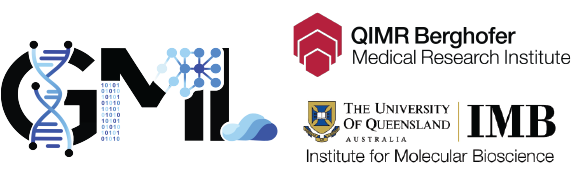


The final and most intensive way to cell type is using spot deconvolution or cell label transfer methods. The aim of these methods is to use an established and annotated scRNA data object as a source and then based on matching cells with similar transcriptional patterns (between the scRNA and Visium/Xenium query dataset), the respective cell type labels will be transferred. For spot deconvolution this method goes one step further, where for each spot the relative proportion of each cell type can be predicted based on expression profiles. 

<br>

**Deconvolution methods:**
* RCTD -> Common deconvolution technology (one of the first)
* STDeconvolve -> A reference free deconvolution method that does not require a scRNA reference
* CARD -> Uses both transcriptional and spatial information to perform spot deconvolution

Deconvolution can only be performed on non single-cell technologies such as Visium. Single cell technologies share a 1:1 ratio when using scRNA datasets so a label transfer method is used

**Label Transfer methods:**
* Seurat Anchor Transfer -> label transfer method implemented in *Seurat*
* UniCellDeconvolve -> A ML based packaged in python that can perform label transfer on an anndata object without the need for a scRNA dataset, because the model has been trained on ~10 million cells

<br>

First we will run *CARD* to deconvolve the Visium data

In [4]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(CARD)
library(png)

In [2]:
## Load Visium Data
visium <- readRDS("/working/joint_projects/P3903/teaching2024-winter-qimr/data/finalised_files_to_move/visium_processed.RDS")

## Load Xenium Data
xenium <- readRDS("/working/joint_projects/P3903/teaching2024-winter-qimr/data/finalised_files_to_move/xenium_processed.RDS")

## Load scRNA Data
 scRNA <- readRDS("/working/joint_projects/P3903/teaching2024-winter-qimr/data/finalised_files_to_move/scRNA_processed.RDS")

In [5]:
## This code will help speed up the plotting when running in base R on a Mac
show_plot <- function(plot, filename = "temp.png") {                                                  
  png(filename = filename, width = 1500, height = 500, res = 100)
  print(plot)                                             
  dev.off()                                    
  img <- readPNG(filename)
  grid::grid.raster(img)
}

#### Visium Deconvolution: CARD

Below we will implement CARD, for more information please visit here: https://yma-lab.github.io/CARD/documentation/04_CARD_Example.html

<br>

First, we will load our single-cell RNA melanoma dataset, and take a look at the annotations

In [ ]:
colour_palette <- list('KC_Cornified' = "#E805A0",
                       'KC_Differentiating' = "#CF0422",
                       'KC_stem/hair/stress' = "#FF052A", 
                       'KC_Basal' = "#F70A5D", 
                       'KC_Granular' = "#F04A84", 
                       'Imm_Bcells' = "#B10EE3", 
                       'Imm_CD8+ T cell' = "#A8F1F7",
                       'Imm_Treg' = "#11B4Fa",
                       'Imm_Tcell' = "#1152F5",
                       'Imm_pDC' = "#99F2D0",
                       'Imm_DC' = "#3EED67", 
                       'Imm_mRegDC' = "#26AD0E",
                       'Imm_NK'= "#387509", 
                       'Imm_Macrophage' = "#CAE05A", 
                       'Imm_LC' = "#F5EB84", 
                       'Imm_Mast Cells' = "#EDD907", 
                       'Imm_Fibroblast' = "#E68613",
                       'Pericytes' = "#CD9600",
                       'Imm_Endothelial cell' = "#ABA300",
                       'Melanocytes' = "#5C4403")


show_plot(DimPlot(scRNA, group.by = "cell_types", cols = colour_palette, pt.size = 0.8))

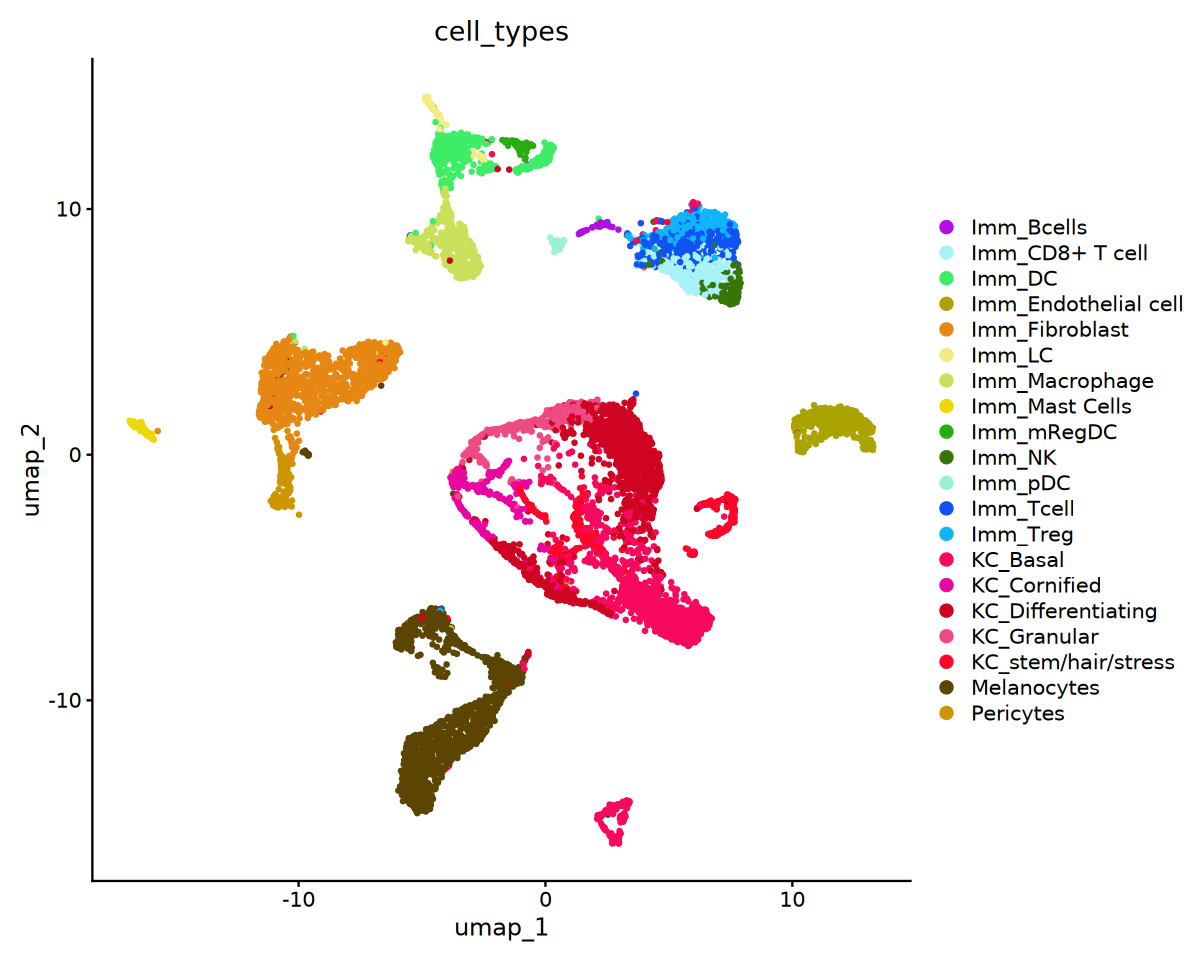

We can see that we have various immune, keratinocytes and other common skin cells annotated in this dataset. We also have melanocytes annotated which will hopefully identify the melanoma cells present in our samples. Now we can run label transfer using CARD. 

NOTE: CARD runs using raw count data and not normalised data, so we will be using data from the "@Spatial$counts" slot

In [6]:
# First we need to change the name of our coordinates to "x" and "y"
visium_coords <- GetTissueCoordinates(visium)
visium_coords$y <- max(visium_coords[["imagerow"]]) - visium_coords[["imagerow"]] + min(visium_coords[["imagerow"]]) # switching the cooridnates so it looks nice
visium_coords$x <- visium_coords[["imagecol"]]
visium_coords <- visium_coords[c("x", "y")]

# First Create a CARD Object using the scRNA and Visium raw data counts

CARD_obj = createCARDObject(
    
	sc_count = scRNA@assays$RNA[["counts"]],
	sc_meta = scRNA@meta.data,
	spatial_count = visium@assays$Spatial[["counts"]],
	spatial_location = visium_coords,
	ct.varname = "cell_types",
	ct.select = unique(scRNA@meta.data$cell_types),
	sample.varname = "sample",
	minCountGene = 100,
	minCountSpot = 3) 

## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...


In [7]:
# Now we can run deconvolution 

CARD_obj = CARD_deconvolution(CARD_object = CARD_obj)

## create reference matrix from scRNASeq...


Loading required package: nnls

Loading required package: TOAST

Loading required package: EpiDISH

Loading required package: limma


Attaching package: ‘limma’


The following object is masked from ‘package:BiocGenerics’:

    plotMA


Loading required package: quadprog

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

MuSiC v1.0.0 support SingleCellExperiment! See Tutorial: https://xuranw.github.io/MuSiC/articles/MuSiC.html

MuSiC2 for multi-condition bulk RNA-seq data is also available!

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.3 GiB”


## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...


In [ ]:
p1 <- CARD.visualize.pie(
	proportion = CARD_obj@Proportion_CARD,
	spatial_location = CARD_obj@spatial_location, 
 	colors = colour_palette, 
  	radius = 3.5) ### You can choose radius = NULL or your own radius number


show_plot(p1)

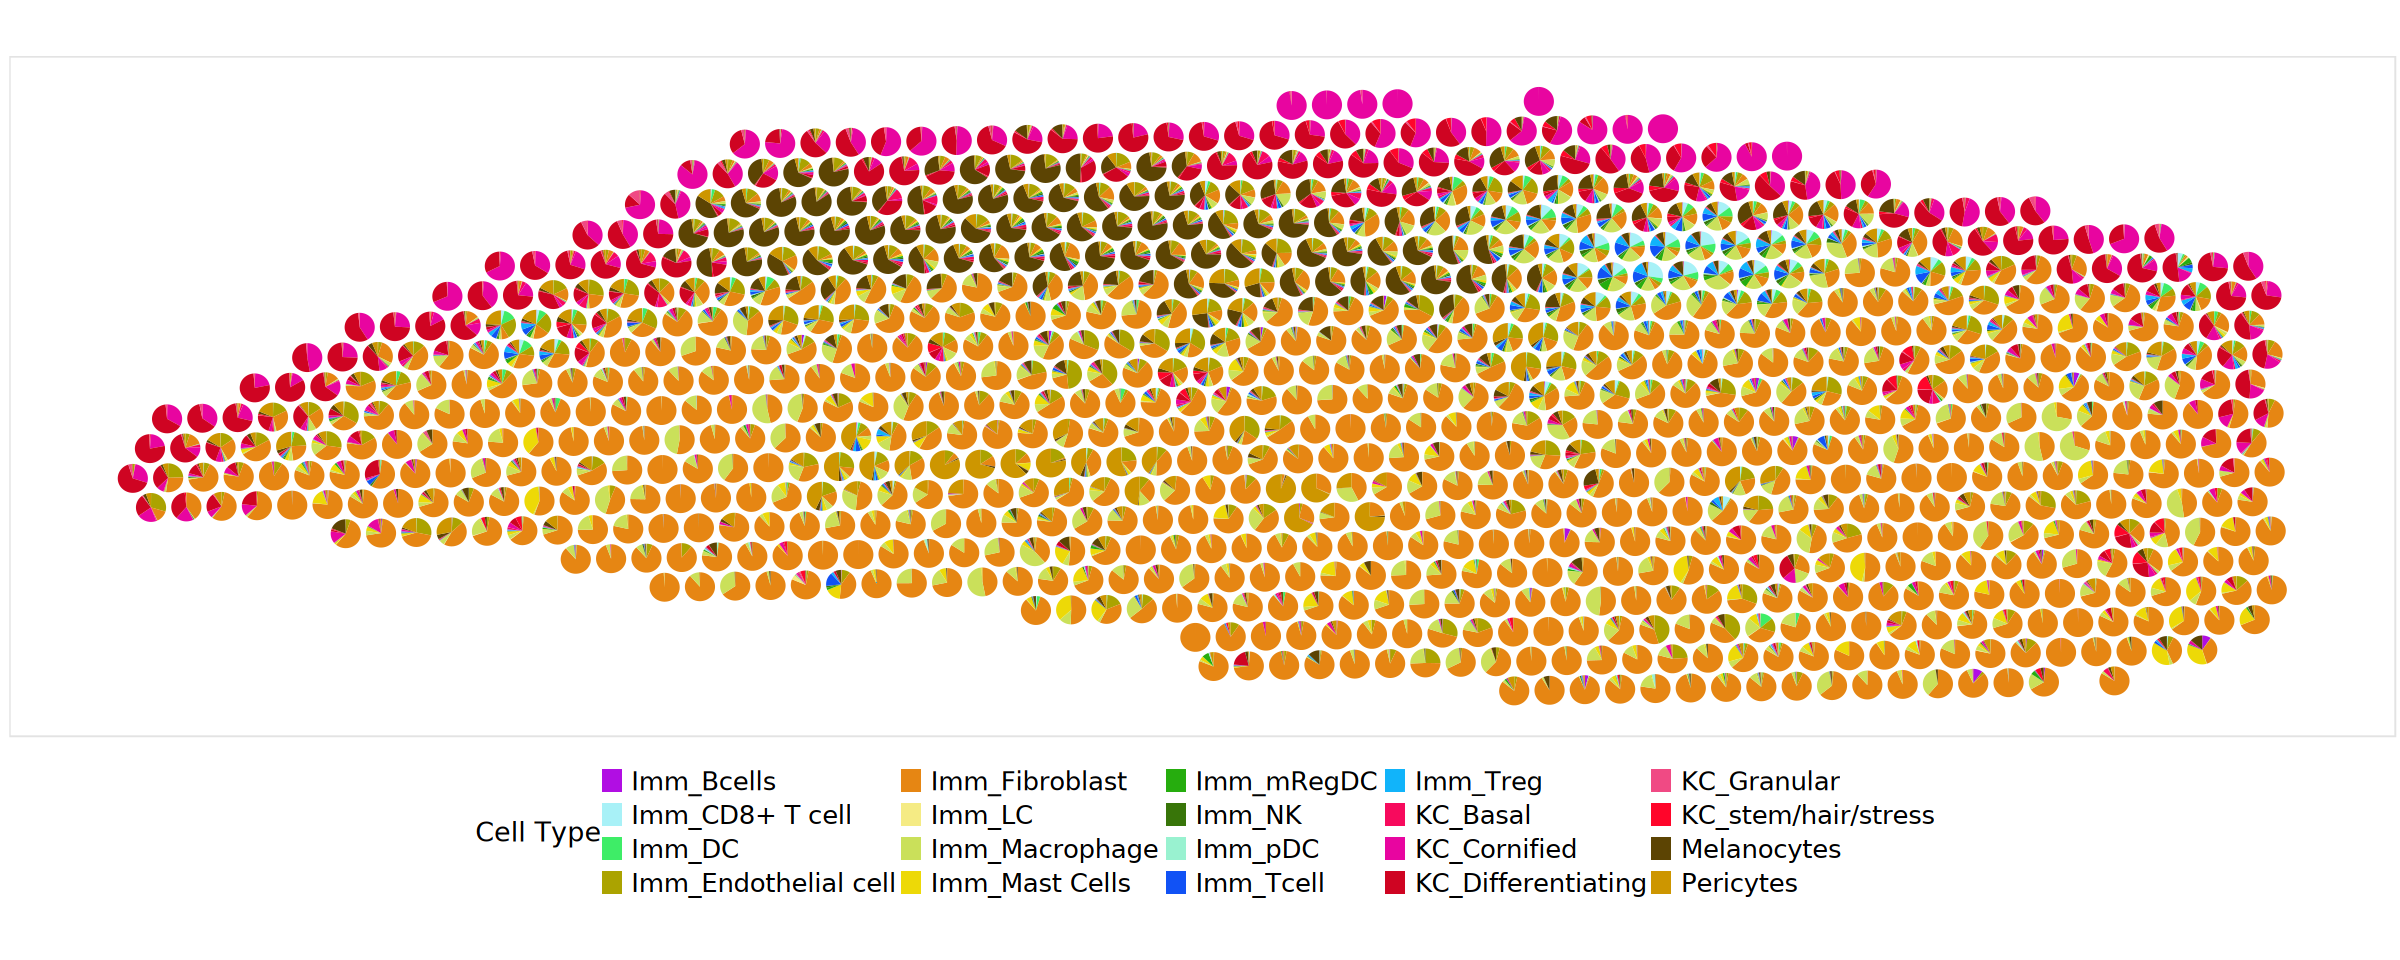

We can see that our deconvolution has worked. Here each spot is represented as a pie graph which contains the relative proportions of each cell type within that spot. We can see key spatial patterns such as our melanoma cells and immune cells. Also we can see the different layers of Keratinocytes in the epidermis. 

Lets look at the raw data table which contains this information:

In [8]:
head(CARD_obj@Proportion_CARD)

# If we need to save this we can by running the code below
#write.csv(CARD_obj@Proportion_CARD, "~Downloads/visium_decon.csv")

KC_Cornified KC_Differentiating Imm_CD8+ T cell
AACACGTGCATCGCAC-1 0.0001743891 9.709853e-05       2.687468e-05   
AACAGGAAGAGCATAG-1 0.0004258617 2.509822e-05       2.887655e-05   
AACATCTAATGACCGG-1 0.0004774220 1.880430e-03       3.426454e-04   
AACATGCGCAAGTGAG-1 0.0287296029 1.514833e-01       5.103523e-04   
AACCAGAATCAGACGT-1 0.0735785239 7.291555e-01       6.591522e-04   
AACCATCGGAAGCGAC-1 0.0380456753 2.048018e-01       3.160783e-03   
                   KC_stem/hair/stress Imm_Treg     Imm_pDC      Imm_Tcell   
AACACGTGCATCGCAC-1 0.0001321210        4.987745e-05 3.910269e-06 1.417862e-04
AACAGGAAGAGCATAG-1 0.0005921353        1.964446e-05 6.285850e-05 9.581879e-05
AACATCTAATGACCGG-1 0.0001256045        6.463540e-04 4.803688e-05 2.902727e-04
AACATGCGCAAGTGAG-1 0.1038670540        4.000098e-04 1.234111e-03 1.490239e-03
AACCAGAATCAGACGT-1 0.0072951117        6.676203e-04 7.366913e-04 6.671188e-04
AACCATCGGAAGCGAC-1 0.1767208508        1.680661e-03 6.021406e-03 5.368246e-03
                   Imm_NK       Imm_Fibroblast Imm_DC       KC_Basal    
AACACGTGCATCGCAC-1 0.0001688803 0.9054021      1.407047e-04 2.348137e-05
AACAGGAAGAGCATAG-1 0.0001488944 0.9382010      9.083538e-05 2.129855e-05
AACATCTAATGACCGG-1 0.0002031760 0.8805079      1.043613e-04 7.538627e-05
AACATGCGCAAGTGAG-1 0.0012694032 0.5843740      7.004899e-03 1.452185e-02
AACCAGAATCAGACGT-1 0.0010711772 0.0289846      2.152916e-03 1.098773e-01
AACCATCGGAAGCGAC-1 0.0024965846 0.2107133      2.843035e-03 8.292832e-02
                   Melanocytes  Imm_Endothelial cell KC_Granular 
AACACGTGCATCGCAC-1 0.0007674506 0.0033353396         4.000937e-06
AACAGGAAGAGCATAG-1 0.0005625911 0.0001493082         3.000229e-06
AACATCTAATGACCGG-1 0.0066395238 0.0057249933         5.301467e-05
AACATGCGCAAGTGAG-1 0.0103403766 0.0445649572         4.491041e-03
AACCAGAATCAGACGT-1 0.0170373629 0.0154925469         3.438838e-04
AACCATCGGAAGCGAC-1 0.0228927940 0.1401235930         9.810109e-03
                   Imm_Macrophage Imm_Bcells   Pericytes    Imm_Mast Cells
AACACGTGCATCGCAC-1 0.005032089    3.256583e-06 2.801896e-04 0.0793447792  
AACAGGAAGAGCATAG-1 0.035067626    2.460514e-04 6.317264e-05 0.0204847979  
AACATCTAATGACCGG-1 0.100708234    2.815790e-04 1.721622e-04 0.0004331408  
AACATGCGCAAGTGAG-1 0.010532591    4.532587e-04 1.305108e-03 0.0252577136  
AACCAGAATCAGACGT-1 0.001584751    1.786450e-04 5.739132e-03 0.0005777048  
AACCATCGGAAGCGAC-1 0.017864808    2.781025e-03 4.757020e-02 0.0038193412  
                   Imm_mRegDC  Imm_LC      
AACACGTGCATCGCAC-1 0.004858785 1.285766e-05
AACAGGAAGAGCATAG-1 0.003585303 1.258560e-04
AACATCTAATGACCGG-1 0.001278760 7.027083e-06
AACATGCGCAAGTGAG-1 0.002426610 5.743549e-03
AACCAGAATCAGACGT-1 0.002307962 1.892285e-03
AACCATCGGAAGCGAC-1 0.017324403 3.033056e-03

We can also look at the relative locations of each cell type individually

In [ ]:
p2 <- CARD.visualize.prop(
	proportion = CARD_obj@Proportion_CARD,        
	spatial_location = CARD_obj@spatial_location, 
	ct.visualize = unique(scRNA@meta.data$cell_types),                 ### selected cell types to visualize
	colors = c("lightblue","lightyellow","red"), ### if not provide, we will use the default colors
	NumCols = 4,                                 ### number of columns in the figure panel
        pointSize = 0.5)                             ### point size in ggplot2 scatterplot  


show_plot(p2)

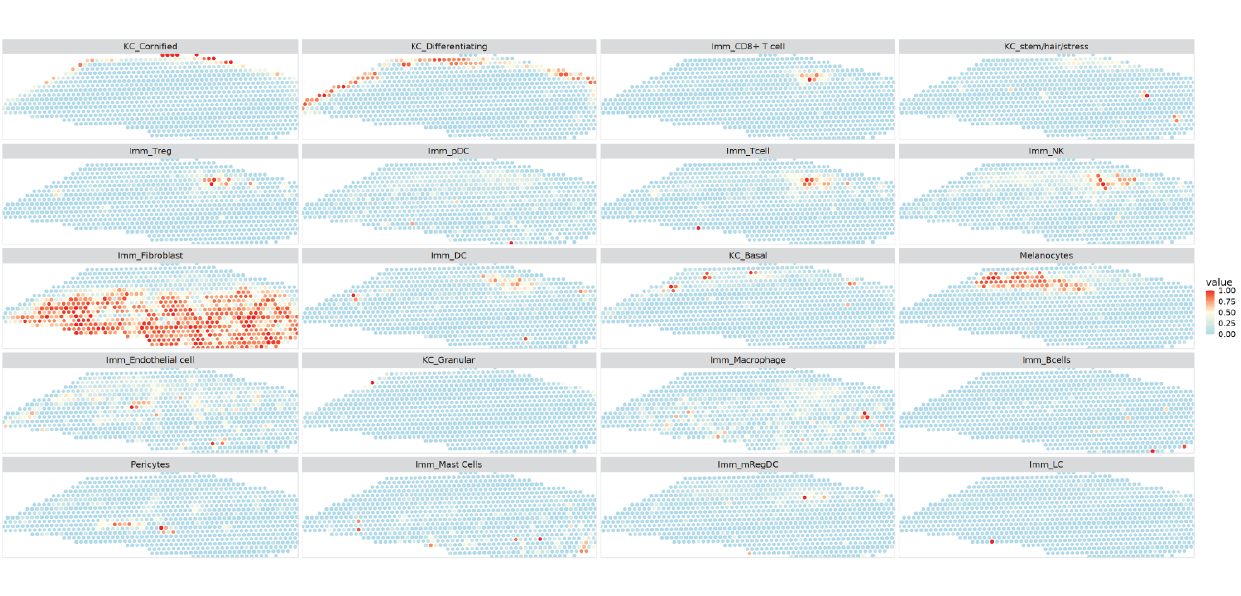

There are some addition ways of visualising the data, if you would like to try some please visit here: https://yma-lab.github.io/CARD/documentation/04_CARD_Example.html

#### Xenium Label Transfer

Now we will run label transfer using the same scRNA dataset on our Xenium data. Here we will use SCTransformed data from both the scRNA and Xenium objects. 

First we will find the common genes between the reference (scRNA) and query (Xenium) datasets

In [12]:
DefaultAssay(scRNA) <- "SCT"
DefaultAssay(xenium) <- "SCT"

In [13]:
common_genes <- intersect(rownames(scRNA), ### Uses only genes which are shared between the reference and xenium datasets
                        rownames(xenium))


cat("There are ", length(common_genes), " common genes shared between the scRNA and Xenium datasets")

There are  250  common genes shared between the scRNA and Xenium datasets

Next we will find transfer anchors. These anchors are essentially pairs of cells between the two datasets that have been identified by the algorithm as being highly similar based on their expression profiles. These archors serve as a point of correspondence between datasets allowing for their alignment and thus transfer of cell labels/information.

For more information about the underlying methods used here please go to: https://doi.org/10.1016/j.cell.2019.05.031

In [14]:
anchors <- FindTransferAnchors(reference = scRNA, query = xenium, features = common_genes, verbose = FALSE)

Warning message in ValidateParams_FindTransferAnchors(reference = reference, query = query, :
“Both reference and query assays have been processed with SCTransform.Setting normalization.method = 'SCT' and continuing.”
Warning message:
“No layers found matching search pattern provided”


Now that we have our anchors we can transfer the labels onto our xenium data! We need to specify the location of these labels, where in our case they are stored in the "cell_types" column of our @meta.data

In [15]:
transfered_labels <- TransferData(anchorset = anchors,
                                              refdata = scRNA$cell_types,  
                                              weight.reduction = xenium[["pca"]], 
                                              dims = 1:30, verbose = FALSE) 

xenium$cell_types <- transfered_labels[["predicted.id"]] #predicted.id is the top most likely label for this cell

Lets look at the results!

In [ ]:
show_plot(ImageDimPlot(xenium, group.by = "cell_types", fov = "fov", cols = colour_palette, size = 1.5))

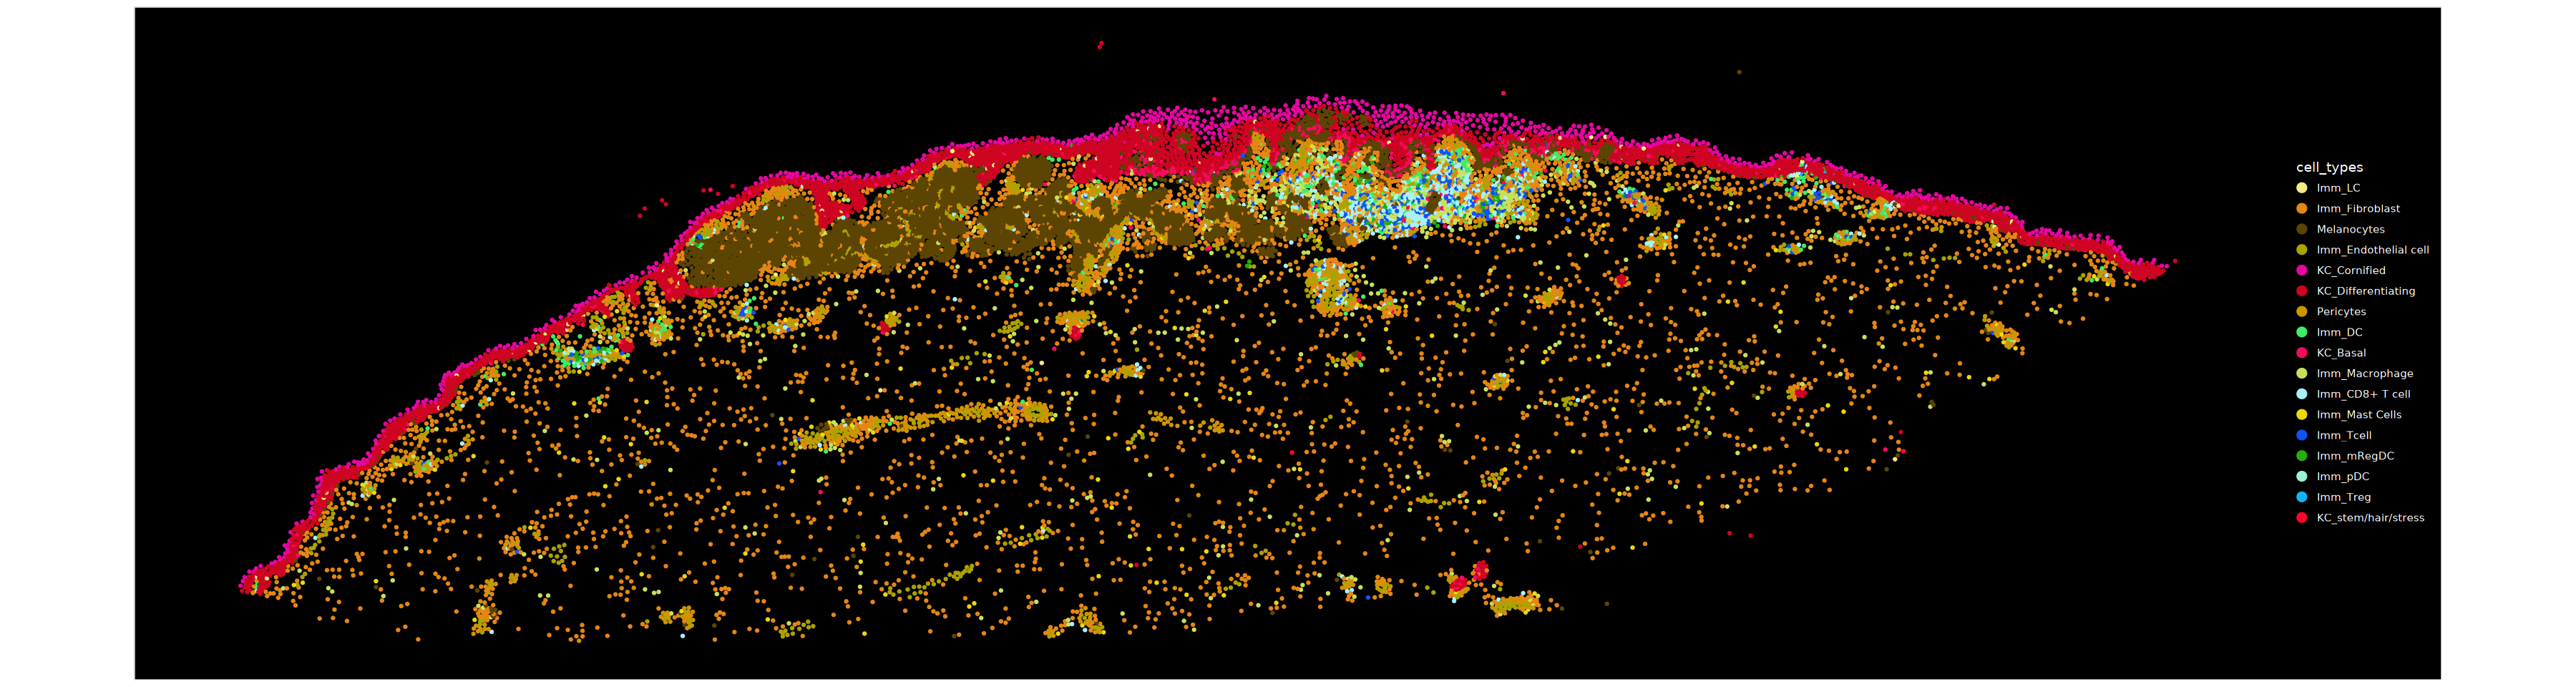

We can see similar to before we have really nice layers of keratinocytes in our epidermis. Additionally we can see our melanoma cells have been labelled as melanocytes, and we were able to identify this cluster of immune cells next to the melanoma region. Based on these three approaches we can confidently identify each cell type within both our visium and xenium samples.

<br>
Lets check that zoomed in region again

In [ ]:
show_plot(ImageDimPlot(xenium, fov = "zoom", group.by = "cell_types", axes = F, border.color = "white", border.size = 0.1, cols = "polychrome",
    coord.fixed = FALSE, molecules = c("PMEL"), nmols = 10000))

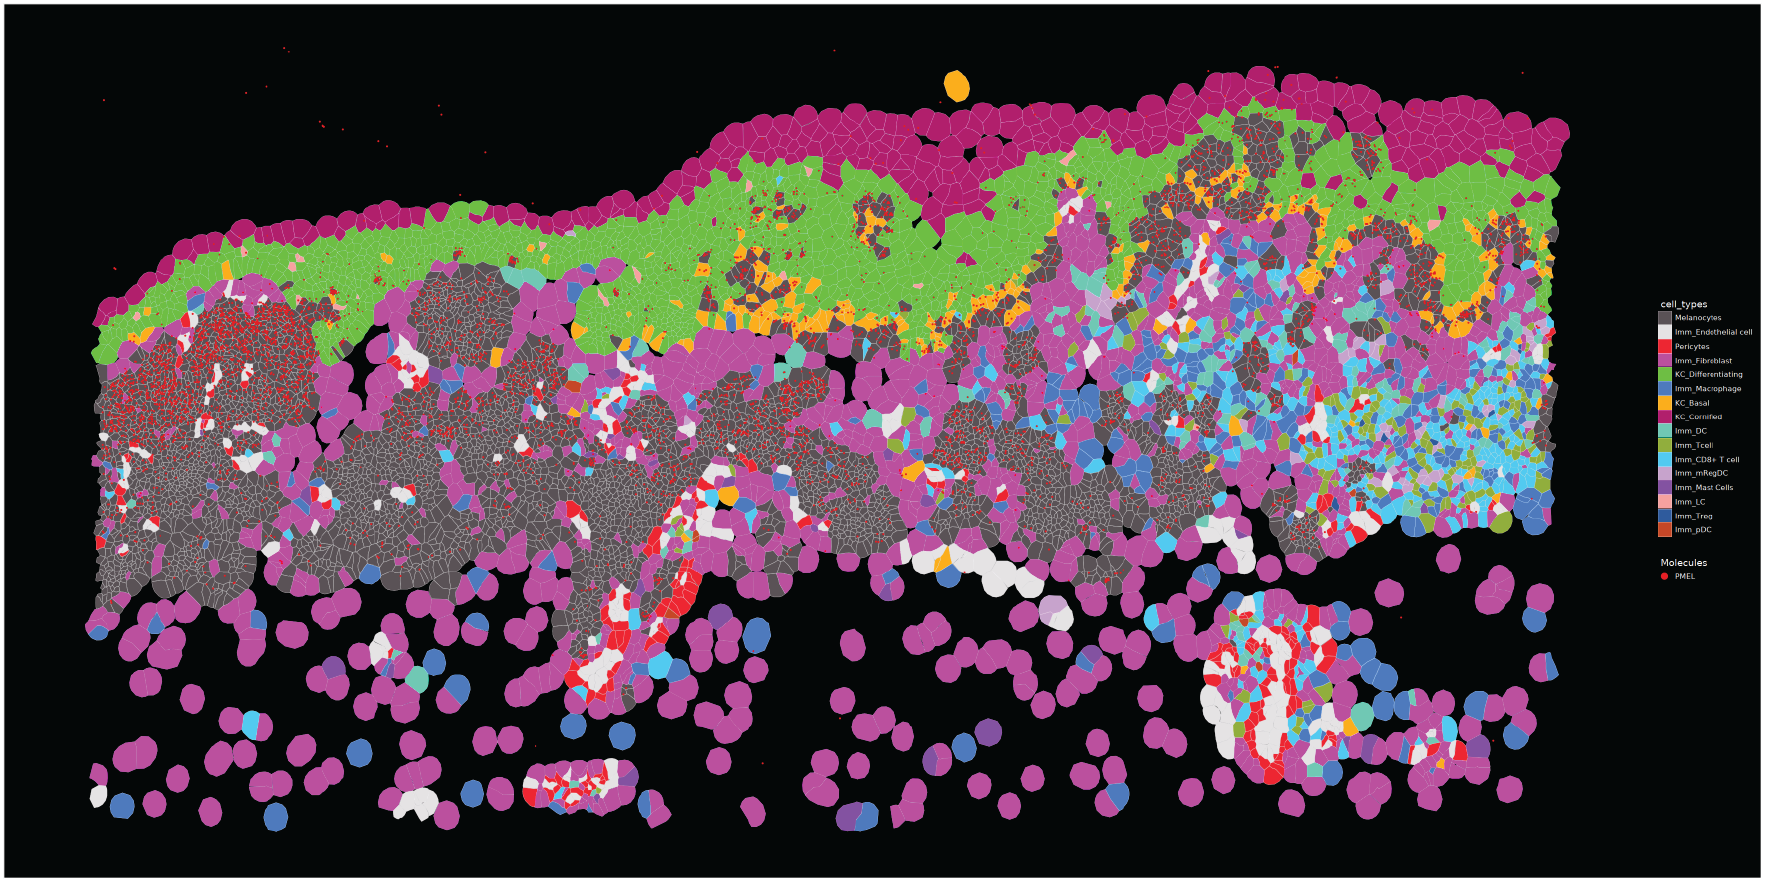

Now that we have our cell types we are able to perform many more downstream analyses to answer various biological questions!

If you have any more questions please feel free to contact the author: uqacause@uq.edu.au.